FileUpload(value={}, accept='.txt', description='Upload')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
[I 2024-07-28 23:59:18,391] A new study created in memory with name: no-name-9823cd77-7ec6-4fd5-931f-f9aa41b77c2e
[I 2024-07-28 23:59:18,546] Trial 0 finished with value: 0.6080211997032166 and parameters: {'clustering_algo': 'AgglomerativeClustering', 'n_clusters': 4, 'linkage': 'average'}. Best is trial 0 with value: 0.6080211997032166.
[I 2024-07-28 23:59:18,652] Trial 1 finished with value: 0.7702847123146057 and parameters: {'clustering_algo': 'DBSCAN', 'eps': 0.7748973756883575, 'min_samples': 3}. Best is trial 1 with value: 0.7702847123146057.
[I 2024-07-28 23:59:18,795] Trial 2 finished with value: 0.7702847123146057 and parameters: {'clustering_algo': 'DBSCAN', 'eps': 0.6670747541473537, 'min_samples': 9}. Best is t

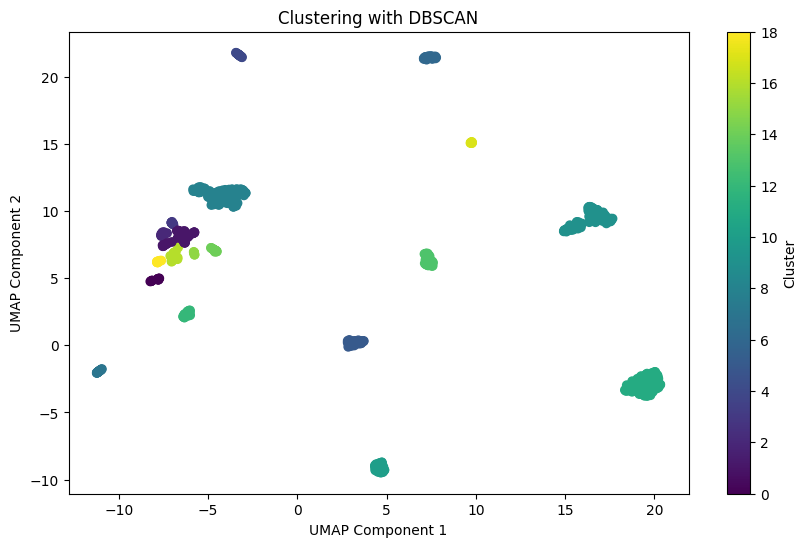

2/2 [==============================] - 0s 6ms/step
0 [D loss: 0.6433562338352203] [G loss: 0.6826959252357483]
2/2 [==============================] - 0s 5ms/step
100 [D loss: 0.10178303718566895] [G loss: 3.3547115325927734]
2/2 [==============================] - 0s 7ms/step
200 [D loss: 0.15322939306497574] [G loss: 3.1251444816589355]
2/2 [==============================] - 0s 6ms/step
300 [D loss: 0.5010744631290436] [G loss: 1.4120397567749023]
2/2 [==============================] - 0s 7ms/step
400 [D loss: 0.5329958200454712] [G loss: 1.4216591119766235]
2/2 [==============================] - 0s 10ms/step
500 [D loss: 0.5506117939949036] [G loss: 1.2199311256408691]
2/2 [==============================] - 0s 6ms/step
600 [D loss: 0.5632835030555725] [G loss: 1.15169358253479]
2/2 [==============================] - 0s 6ms/step
700 [D loss: 0.616150438785553] [G loss: 1.2607171535491943]
2/2 [==============================] - 0s 6ms/step
800 [D loss: 0.6656733155250549] [G loss: 0.899

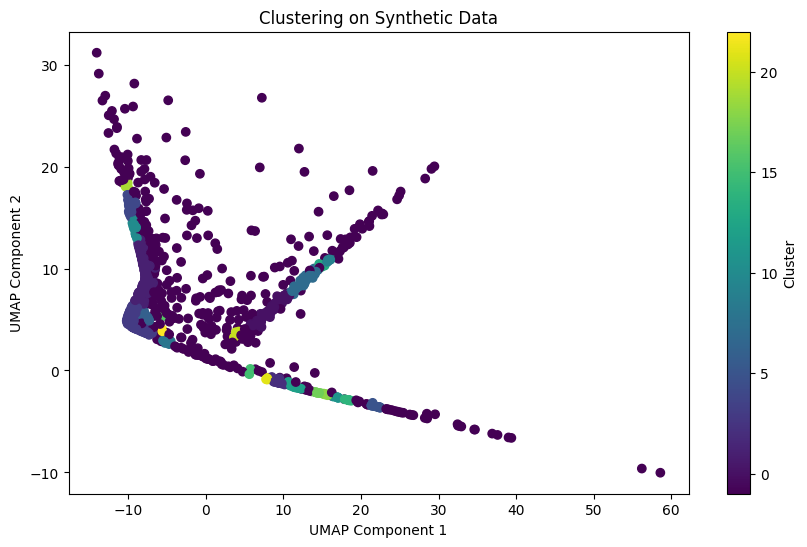

In [ ]:
# Install necessary packages
!pip install numpy pandas scipy scikit-learn matplotlib umap-learn optuna keras tensorflow

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap
import optuna
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.neighbors import LocalOutlierFactor
from ipywidgets import FileUpload
from io import StringIO

# Create file upload widget
upload = FileUpload(accept='.txt', multiple=False)

def on_upload_change(change):
    # Load the uploaded file into a pandas DataFrame
    uploaded_file = list(change['new'].values())[0]
    content = uploaded_file['content']
    data = pd.read_csv(StringIO(content.decode('utf-8')), sep=" ", header=None)
    data.columns = ['source', 'target']

    # Create adjacency matrix
    nodes = list(set(data['source']).union(set(data['target'])))
    node_dict = {node: idx for idx, node in enumerate(nodes)}
    num_nodes = len(nodes)

    # Create a sparse adjacency matrix
    rows = []
    cols = []
    for src, tgt in zip(data['source'], data['target']):
        rows.append(node_dict[src])
        cols.append(node_dict[tgt])
        rows.append(node_dict[tgt])
        cols.append(node_dict[src])
    adj_matrix = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(num_nodes, num_nodes))

    # Standardize the features
    scaler = StandardScaler(with_mean=False)  # `with_mean=False` is required for sparse input
    adj_matrix_scaled = scaler.fit_transform(adj_matrix)

    # Outlier Detection
    lof = LocalOutlierFactor()
    outliers = lof.fit_predict(adj_matrix_scaled.toarray())
    inliers = adj_matrix_scaled[outliers == 1]

    # Dimensionality Reduction with UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(inliers.toarray())

    # Hyperparameter Optimization using Optuna
    def objective(trial):
        clustering_algo = trial.suggest_categorical('clustering_algo', ['KMeans', 'DBSCAN', 'AgglomerativeClustering'])
        if clustering_algo == 'KMeans':
            n_clusters = trial.suggest_int('n_clusters', 2, 10)
            model = KMeans(n_clusters=n_clusters, random_state=42)
        elif clustering_algo == 'DBSCAN':
            eps = trial.suggest_float('eps', 0.1, 1.0)
            min_samples = trial.suggest_int('min_samples', 3, 10)
            model = DBSCAN(eps=eps, min_samples=min_samples)
        else:
            n_clusters = trial.suggest_int('n_clusters', 2, 10)
            linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)

        labels = model.fit_predict(X_umap)
        if len(set(labels)) > 1:
            return silhouette_score(X_umap, labels)
        else:
            return -1.0

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_params

    # Train the best model
    if best_params['clustering_algo'] == 'KMeans':
        model = KMeans(n_clusters=best_params['n_clusters'], random_state=42)
    elif best_params['clustering_algo'] == 'DBSCAN':
        model = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
    else:
        model = AgglomerativeClustering(n_clusters=best_params['n_clusters'], linkage=best_params['linkage'])

    labels = model.fit_predict(X_umap)

    # Plotting the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title(f'Clustering with {best_params["clustering_algo"]}')
    plt.colorbar(label='Cluster')
    plt.show()

    # Generate Synthetic Data with GAN
    def build_generator():
        model = Sequential()
        model.add(Dense(128, activation='relu', input_dim=2))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(2, activation='linear'))
        return model

    def build_discriminator():
        model = Sequential()
        model.add(Dense(512, activation='relu', input_dim=2))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        return model

    optimizer = 'adam'

    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    generator = build_generator()
    gan_input = Input(shape=(2,))
    generated_data = generator(gan_input)
    discriminator.trainable = False
    validity = discriminator(generated_data)
    combined = Model(gan_input, validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    # Training the GAN
    def train_gan(X, epochs=1000, batch_size=64):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_data = X[idx]

            noise = np.random.normal(0, 1, (batch_size, 2))
            generated_data = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(real_data, valid)
            d_loss_fake = discriminator.train_on_batch(generated_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = combined.train_on_batch(noise, valid)

            if epoch % 100 == 0:
                print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

    train_gan(X_umap)

    # Generate synthetic data
    synthetic_data = generator.predict(np.random.normal(0, 1, (X_umap.shape[0], 2)))

    # Apply clustering on synthetic data
    labels_synthetic = model.fit_predict(synthetic_data)

    # Plotting the synthetic clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], c=labels_synthetic, cmap='viridis')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('Clustering on Synthetic Data')
    plt.colorbar(label='Cluster')
    plt.show()

# Display the file upload widget and set the callback
upload.observe(on_upload_change, names='value')
display(upload)
